## Summary

__Changes__

Added 2 new columns, SepsisClassifier and SepsisOnset. SepsisClassifier False if patient never has sepsis during hospital stay, True if they do. SepsisOnset 1 for hour of sepsis onset, 0 everything else.

__Notes__

_Vital Signs_ - According to the [Mayo clinic](https://www.mayoclinic.org/diseases-conditions/sepsis/symptoms-causes/syc-20351214?utm_source=Google&utm_medium=abstract&utm_content=Sepsis&utm_campaign=Knowledge-panel), symptoms of sepsis include fever, difficulty breathing, low blood pressure, and fast heart rate. That is reflected in the time course data, certainly after sepsis onset, in sepsis vs. non sepsis patients. Sepsis patients have consistently higher average respiration & heart rate at any point compared to non-sepsis patients. Decrease in blood pressure is clearly seen in all sepsis patients post sepsis onset; pre-sepsis onset, SBP shows the strongest downward trend a few hours out, with MAP and DBP not as clear. O2Sat is a bit puzzling, as you'd expect it to clearly go down for sepsis patients, more so than non-sepsis patients. They actually show the same slight downward trend, so not much to conclude now.

_Lab Values_ - Few clear differences in lab values between two groups. Most observed differences in distributions may be attributed to limited sample size (e.g. very few values available for Bilirubin_direct). The only exception is Bilirubin_Total, having lab values for over 30% of patients, and a seemingly different distribution between the two groups.

_Demographic Values_ -
Nearly 1.5x as much sepsis seen at HospitalA than Hospital B. Slightly more than 1.5x as much sepsis seen in MICU than SICU. Sepsis seen slightly more in males than females. Different groups have similar age mean of ~61, with sepsis seeing a slightly larger spread. Sepsis patients stay at the hospital much longer than non-sepsis patients. 


## Code Navigation

* [1. Import Libraries & Data](#1.ImportLibraries&Data)
* [2. Add New Classifier Columns](#2.AddNewClassifierColumns)
* [3. General Data Exploration](#3.GeneralDataExploration)
* [4. Exploring Vital Signs](#4.ExploringVitalSigns)
* [5. Exploring Lab Values](#5.ExploringLabValues)
* [6. Exploring Demographic Values](#6.ExploringDemographicValues)
* [7. Save Data](#7.SaveData)

## 1. Import Libraries & Data <a class="anchor" id="1.ImportLibraries&Data"></a>

In [1]:
import glob, os
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
os.chdir("../src/data")
from Custom_Func import percent_there

In [3]:
os.chdir("../../data/interim")

In [4]:
df=pd.read_csv('sepsis_data_cleaned.csv',index_col=0)

C:\Users\amcas\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## 2. Add New Classifier Columns <a class="anchor" id="2.AddNewClassifierColumns"></a>

In [5]:
#Add new column to df that classifies if a patient has sepsis at all during their stay: 'SepsisClassifier'
Sepsis_id=df.groupby(['id'])[['SepsisLabel']].sum()
b=np.array(np.where(Sepsis_id['SepsisLabel']>0,'Sepsis','No Sepsis'))
a=np.array(range(df['id'].nunique()))
dict = {a[i]: b[i] for i in range(len(b))} 
df['SepsisClassifier']=df['id'].map(dict)

In [6]:
#Add new column to df that specifies spesis onset; 1 for hour of sepsis onset, 0 everything else: 'SepsisOnset'

#Select all columns and time points of patients that ever develop sepsis in temporary df
df_Sep=df.loc[df.SepsisClassifier=='Sepsis']
#Slice for id, SepsisLabel and vital sign data of interest in new df called df_Sep_pat_var
df_Sep_slice=df_Sep.loc[:,['id','SepsisLabel']]
#Determine the index of sepsis onset for each patient
id_Sep_Init=df_Sep_slice.groupby('id').idxmax()
#Create new column in df_Sep_pat_var df called Sepsis Onset with all values set to 0
df['SepsisOnset']=0
#Where sepsis onset occurs, change value of SepsisOnset to 1.
for i in id_Sep_Init.SepsisLabel:
    df.loc[i,'SepsisOnset']=1
#Assert that there are the same number of sepsis onset points as number of sepsis patients
print(df.SepsisOnset.value_counts()[1]==df.groupby('SepsisClassifier')['id'].nunique()[1])

True


## 3. General Data Exploration <a class="anchor" id="3.GeneralDataExploration"></a>

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
HR,1398811.0,84.581443,17.325242,20.00,72.00,83.500,95.50,280.00
O2Sat,1349474.0,97.193955,2.936924,20.00,96.00,98.000,99.50,100.00
Temp,525208.0,36.977499,0.767254,30.00,36.50,37.000,37.50,42.22
SBP,1325666.0,123.748103,23.212296,20.00,107.00,121.000,138.00,299.00
MAP,1358673.0,82.391894,16.296982,20.00,71.00,80.000,92.00,300.00
DBP,1065377.0,63.807702,13.835094,20.00,54.00,62.000,72.00,300.00
Resp,1313875.0,18.726498,5.098194,1.00,15.00,18.000,21.50,100.00
EtCO2,57636.0,32.957657,7.951662,10.00,28.00,33.000,38.00,100.00
BaseExcess,84145.0,-0.691221,4.277336,-32.00,-3.00,0.000,1.00,30.00
HCO3,65028.0,24.075634,4.375746,5.00,22.00,24.000,26.80,55.00


In [ ]:
Plot Correlation between variables
plt.subplots(figsize=(12,10))
sns.heatmap(df.corr());

No strong correlations of note distinguishable here - there are strong correlations between values you'd expect, like the blood pressure values or some of the lab values (Billirubin Direct & Total, for example).

In [8]:
#Prevalence of Sepsis in the Data Set
prevalence_patient=round(sum(df.groupby('id')['SepsisOnset'].sum())/len(df.groupby('id'))*100,2)
prevalence_hour=round(sum(df['SepsisLabel'])/len(df)*100,2)

str1="Of {} patients available in the data set, {}% develop sepsis at some point during their hospital stay.".format(df['id'].nunique(),prevalence_patient)
str2="Of the {} data points in the data set (each one representing an hour) {}% occur while a patient has sepsis.".format(len(df),prevalence_hour)
print(str1)
print(str2)

Of 40336 patients available in the data set, 7.27% develop sepsis at some point during their hospital stay.
Of the 1552210 data points in the data set (each one representing an hour) 1.8% occur while a patient has sepsis.


This is a very imbalanced dataset.

## 4. Exploring Vital Signs <a class="anchor" id="4.ExploringVitalSigns"></a>

First I will determine where sepsis first occurs for each sepsis patient. Then I will plot the average time course for each vital sign by patient group. The Sepsis patients' data will be plotted relative to sepsis onset (time point 0) while the non-sepsis group will be plotted based on a time range of the same size, centered where most patients are in the ICU and have data points available.

In [9]:
#First, the df is sliced into all of the data from sepsis patients only. Then, the column 'SepsisAxis' is added, which 
#is the hour relative to sepsis onset; -6 for 6 hours before onset, 8 for 8 hours after onset, and so on.
Sepsis_Patients=df[df.SepsisClassifier=='Sepsis'].copy()
Non_Sepsis_Patients=df[df.SepsisClassifier=='No Sepsis'].copy()
Sepsis_id=Sepsis_Patients.id.unique()
Sepsis_Patients['Sepsis_Axis']=0
for i in Sepsis_id:
    patient=Sepsis_Patients[Sepsis_Patients.id==i]
    patient.reset_index(inplace=True)
    mid=(patient.loc[patient.SepsisOnset==1].index.tolist())[0]
    n=len(patient)
    time=np.linspace(-mid, n-mid-1,n)
    Sepsis_Patients.loc[Sepsis_Patients.id==i,'Sepsis_Axis']=time

In [10]:
#This function obtains the averages of the data column of interest relative to sepsis onset for each sepsis patient, from 
#36 hours before onset to 10 hours after. 
#It also gets the averages from the same variable in non-sepsis patients, with the range specified as 10 hours into ICU
#stay to 56 hours in  - this interval was chosen as a compromise because there are significantly more NaNs earlier in 
#patients' stays that seem to throw off the trends, but only 25% of non sepsis patients stay longer than 47 hours.
def VitalSigns_Averaged_Overtime(df1,df2,variable_list):
    Average={}
    time=list(range(-36,10))
    time_=list(range(10,56))
    for var in variable_list:
        #Get averages overtime for Sepsis Patients
        Avg_Sep=[]
        time=list(range(-36,10))
        for i in time:
            Avg_Sep.append(df1.loc[df1['Sepsis_Axis']==i][var].mean())
        #Get averages overtime for Non Sepsis Patients
        Avg_NoSep=[]
        for i in time_:
            Avg_NoSep.append(df2.loc[df2['ICULOS']==i][var].mean())
        Average[var]=[Avg_Sep,Avg_NoSep]
    i=1
    plt.rcParams['figure.figsize'] = (12,10)
    for var in variable_list:
        plt.subplot(4,2,i)
        plt.plot(time,Average[var][0],label='Sepsis',c='orange')
        plt.plot(time,Average[var][1],label='No Sepsis',c='deepskyblue')
        plt.xlabel('Time (Hour)',size=12)
        plt.ylabel(var,size=12)
        plt.title(var,size=12)
        plt.axvline(0,c='red',lw=3)
        plt.legend(loc='lower right')
        i=i+1
    plt.suptitle('Vital Signs Overtime Relative to Sepsis Onset')
    plt.tight_layout()
    plt.show()

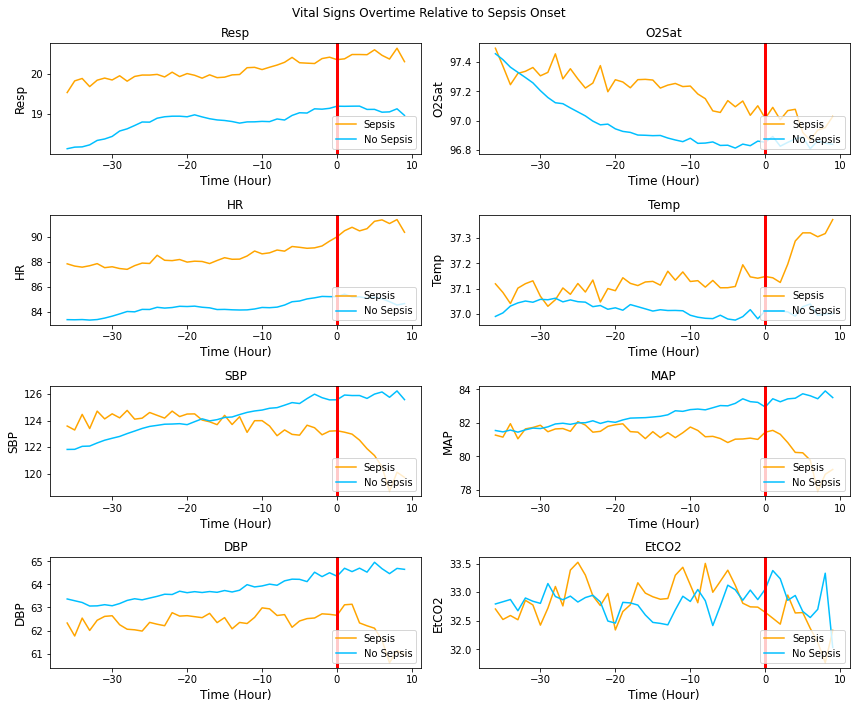

In [11]:
var_list=['Resp','O2Sat','HR','Temp','SBP','MAP','DBP','EtCO2']
VitalSigns_Averaged_Overtime(Sepsis_Patients,Non_Sepsis_Patients,var_list)

## 5. Exploring Lab Values <a class="anchor" id="5.ExploringLabValues"></a>

In [12]:
#Create new df called df_lab - only lab values and SepsisClassifier column
df_lab=df.loc[:,'BaseExcess':'Platelets']
df_lab['SepsisClassifier']=df['SepsisClassifier']
df_lab_norm=df_lab.copy()

In [13]:
#Melt the df so that all lab values are stacked in the same column, create new cummulative 'Value' column
df_lab_melted=pd.melt(df_lab,id_vars='SepsisClassifier',var_name='Lab_Name',value_name='Value')
#Calculate summary statistics for each combination of lab value and sepsis group
func={'Value':['max','min','median','mean','std']}
df_lab_melted.groupby(['Lab_Name','SepsisClassifier']).aggregate(func)

Value                             \
                                       max    min  median        mean   
Lab_Name         SepsisClassifier                                       
AST              No Sepsis         9961.00   3.00   39.00  245.814501   
                 Sepsis            9840.00   4.00   57.00  337.214736   
Alkalinephos     No Sepsis         3000.00  11.00   73.00  101.582527   
                 Sepsis            1185.00   7.00   78.00  106.517272   
BUN              No Sepsis          268.00   1.00   17.00   23.061279   
                 Sepsis             201.00   1.00   22.00   29.566960   
BaseExcess       No Sepsis           30.00 -32.00    0.00   -0.776379   
                 Sepsis              21.00 -23.00    0.00   -0.308312   
Bilirubin_direct No Sepsis           30.00   0.01    0.40    1.520818   
                 Sepsis              30.00   0.08    0.90    3.310096   
Bilirubin_total  No Sepsis           49.60   0.10    0.80    1.871508   
                 Sepsis              45.90   0.10    1.20    3.503635   
Calcium          No Sepsis           21.00   1.00    8.30    7.629252   
                 Sepsis              20.00   1.00    8.10    7.115581   
Chloride         No Sepsis          145.00  63.00  106.00  105.828349   
                 Sepsis             137.00  73.00  106.00  105.831177   
Creatinine       No Sepsis           25.00   0.10    0.91    1.491560   
                 Sepsis              20.49   0.10    1.10    1.640471   
FiO2             No Sepsis            1.00   0.00    0.50    0.524265   
                 Sepsis               1.00   0.00    0.50    0.524445   
Fibrinogen       No Sepsis         1100.00  34.00  251.00  285.641136   
                 Sepsis            1100.00  35.00  243.00  294.959153   
Glucose          No Sepsis          960.00  10.00  126.00  136.786697   
                 Sepsis             988.00  11.00  129.00  138.039756   
HCO3             No Sepsis           55.00   5.00   24.00   24.100433   
                 Sepsis              45.00   5.00   24.00   23.937971   
Hct              No Sepsis           71.70  10.00   30.40   30.893079   
                 Sepsis              65.00  12.80   29.50   30.092498   
Hgb              No Sepsis           25.00   2.20   10.30   10.466495   
                 Sepsis              23.40   4.10   10.00   10.181304   
Lactate          No Sepsis           31.00   0.20    1.80    2.643616   
                 Sepsis              21.52   0.30    1.85    2.657246   
Magnesium        No Sepsis            9.80   0.20    2.00    2.043746   
                 Sepsis               9.60   0.70    2.10    2.098406   
PTT              No Sepsis          250.00  12.50   32.20   40.951823   
                 Sepsis             250.00  18.30   33.70   42.845750   
PaCO2            No Sepsis          100.00  10.00   40.00   41.016490   
                 Sepsis             100.00  15.00   40.00   41.045812   
Phosphate        No Sepsis           18.80   0.20    3.30    3.532234   
                 Sepsis              16.40   0.40    3.30    3.612100   
Platelets        No Sepsis         1100.00   1.00  182.00  197.228314   
                 Sepsis            1081.00   2.00  168.00  186.861360   
Potassium        No Sepsis           13.00   1.30    4.10    4.139946   
                 Sepsis              11.50   1.00    4.00    4.106872   
SaO2             No Sepsis          100.00  30.00   97.00   92.521725   
                 Sepsis             100.00  30.00   97.00   93.365205   
TroponinI        No Sepsis          300.00   0.01    0.28    8.017107   
                 Sepsis             226.78   0.01    0.44   10.754708   
WBC              No Sepsis          300.00   0.10   10.20   11.285801   
                 Sepsis             224.90   0.10   11.30   12.499623   
pH               No Sepsis            7.80   6.80    7.38    7.377754   
                 Sepsis               7.73   6.81    7.39    7.384402   

                     

In [14]:
#Normalize all lab values
df_lab_norm.loc[:,'BaseExcess':'Platelets']=(df.loc[:,'BaseExcess':'Platelets']-df.loc[:,'BaseExcess':'Platelets'].min())/(df.loc[:,'BaseExcess':'Platelets'].max()-df.loc[:,'BaseExcess':'Platelets'].min())
#Melt the df so that all lab values are stacked in the same column, create new cummulative 'Relative Value' column
df_lab_norm_melted=pd.melt(df_lab_norm,id_vars='SepsisClassifier',var_name='Lab_Name',value_name='Relative_Value')

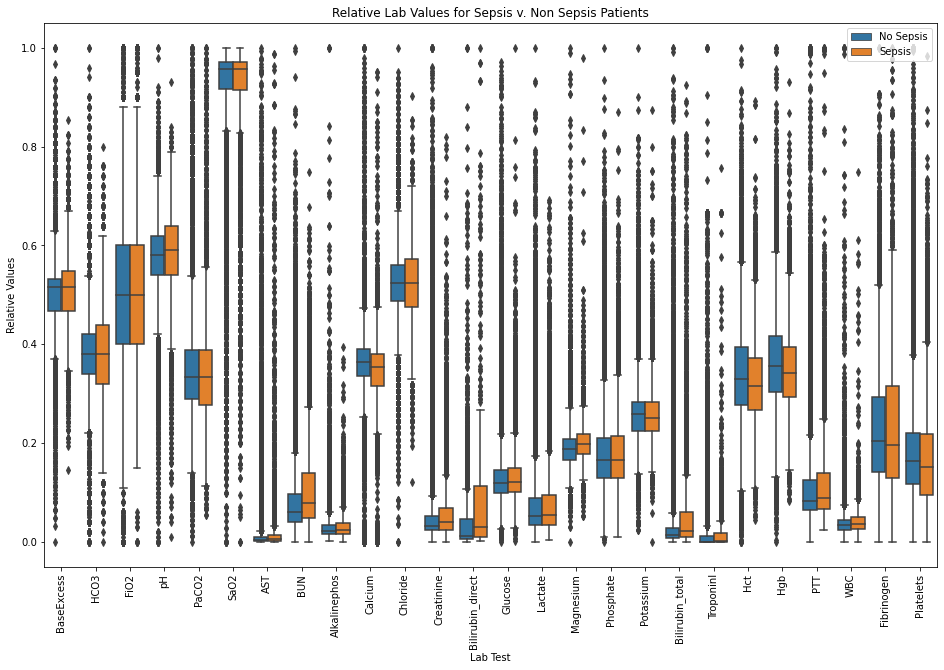

In [15]:
#Plot the distributions with boxplots
plt.subplots(figsize=(16,10))
sns.boxplot(x='Lab_Name',y='Relative_Value',hue='SepsisClassifier',data=df_lab_norm_melted)
plt.xticks(rotation='vertical')
plt.ylabel('Relative Values')
plt.xlabel('Lab Test')
plt.title('Relative Lab Values for Sepsis v. Non Sepsis Patients')
plt.legend(loc='upper right')
plt.show()

Almost no clear patterns between the groups for any of these variables. For example, while there is a visual difference in distributions between groups for Bilirubin direct, that could easily be attributed to the small number of lab values avaialable (i.e. noise). Bilirubin_total is the only exception, having lab values for over 30% of patients, and a seemingly different distribution. 

Taking a step back fromt the lab values, is the presence of a lab value predictive of sepsis? 

In [17]:
df_=pd.concat([df.loc[:,'EtCO2':'Platelets'],df[['id']],df[['SepsisClassifier']]],axis=1)
GB=df_.groupby(['id','SepsisClassifier']).sum().reset_index().drop(columns='id')

In [18]:
pd.set_option('display.max_rows', None)

dict_=percent_there(GB,'EtCO2','Platelets','SepsisClassifier')
index_=['No Sepsis','Sepsis','Percent']
pd.DataFrame(dict_,index=index_).T.sort_values(by='Percent',ascending=False)

,No Sepsis,Sepsis,Percent
EtCO2,2689.0,527.0,16.39
Bilirubin_direct,1737.0,320.0,15.56
Lactate,10674.0,1819.0,14.56
BaseExcess,4433.0,687.0,13.42
Fibrinogen,3930.0,585.0,12.96
FiO2,15605.0,2196.0,12.34
PaCO2,16156.0,2200.0,11.99
pH,16710.0,2225.0,11.75
SaO2,11586.0,1502.0,11.48
Alkalinephos,12556.0,1617.0,11.41


Yes, there is some information in whether or not a lab was ordered for a patient (I included ETCO2 bc its so rare).

## 6. Exploring Demographic Values <a class="anchor" id="6.ExploringDemographicValues"></a>

In [19]:
#Function to calculate percentage difference for specified categorical variable between sepsis groups
def categorical_difference(Cat1,Cat2,val1,val2):
    Sepsis_by_pat_1=np.array(df.loc[df[Cat1]==val1].groupby(['id'])[['SepsisLabel']].sum())
    Sepsis_by_pat_2=np.array(df.loc[df[Cat2]==val2].groupby(['id'])[['SepsisLabel']].sum())
    A_n=Sepsis_by_pat_1.size
    B_n=Sepsis_by_pat_2.size
    A=np.array([1 if i > 0 else 0 for i in np.nditer(Sepsis_by_pat_1)]).sum()
    B=np.array([1 if i > 0 else 0 for i in np.nditer(Sepsis_by_pat_2)]).sum()
    A_Sep=round(A/A_n*100,2)
    B_Sep=round(B/B_n*100,2)
    return A_Sep,B_Sep

In [20]:
#Determine the percent difference in sepsis group for each hospital, hospital unit, and gender
A,B =categorical_difference('HospitalA','HospitalA',1,0)
str=' {}% of patients at hospital A had sepsis compared to {}% at hospital B.'.format(A,B)
print(str)

A,B =categorical_difference('Unit1','Unit2',1,1)
str=' {}% of patients in the MICU had sepsis compared to {}% in the SICU.'.format(A,B)
print(str)

A,B =categorical_difference('Gender','Gender',1,0)
str=' {}% of males had sepsis compared to {}% females.'.format(A,B)
print(str)

 8.8% of patients at hospital A had sepsis compared to 5.71% at hospital B.
 7.87% of patients in the MICU had sepsis compared to 5.22% in the SICU.
 7.71% of males had sepsis compared to 6.71% females.


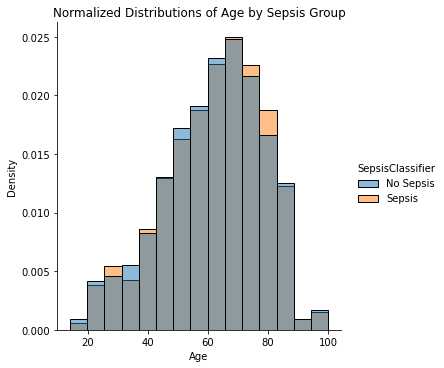

In [21]:
#Create a plot of the normalized distribution of age by sepsis group
df_age=df[['SepsisClassifier','id','Age']].groupby('id').first()
sns.displot(data=df_age,x='Age',hue='SepsisClassifier',stat='density',common_norm=False,bins=15)
plt.title('Normalized Distributions of Age by Sepsis Group')
plt.show()

In [22]:
#Summary stats on age for different sepsis groups
func={'Age':['median','mean','std','max','min']}
df_age.groupby('SepsisClassifier').aggregate(func)

Age                                   
                 median       mean        std    max   min
SepsisClassifier                                          
No Sepsis         63.04  61.611084  16.491078  100.0  14.0
Sepsis            64.00  62.055982  16.376043  100.0  17.0

In [23]:
#The Sepsis group has a slightly larger average spread of ages compared to the non-sepsis group, std of 16.8 compared to 16.2.'

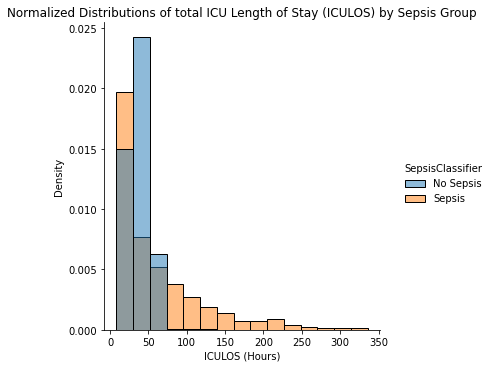

In [24]:
#Create a plot of the normalized distribution of total ICULOS by sepsis group
df_ICULOS=df[['SepsisClassifier','id','ICULOS']].groupby('id').last()
sns.displot(data=df_ICULOS,x='ICULOS',hue='SepsisClassifier',stat='density',common_norm=False,bins=15)
plt.title('Normalized Distributions of total ICU Length of Stay (ICULOS) by Sepsis Group')
plt.xlabel('ICULOS (Hours)')
plt.show()

In [25]:
#Summary stats on ICULOS for different sepsis groups
func={'ICULOS':['median','mean','std','max','min']}

print('Summary Statistics for ICULOS by Sepsis Groups')
df_ICULOS.groupby('SepsisClassifier').aggregate(func)

Summary Statistics for ICULOS by Sepsis Groups


ICULOS                               
                 median       mean        std  max min
SepsisClassifier                                      
No Sepsis            39  37.410437  15.956682  336   8
Sepsis               38  59.417462  59.445450  336   8

Unsurprisingly, patients that develop sepsis have a much longer hospital stay, on average. So now the question, on average when does sepsis appear? Compared to average/median stay of those that don't develop sepsis?

In [26]:
df_=df.loc[df.SepsisClassifier=='Sepsis'].copy()
df_=df_.loc[df_.SepsisOnset==1]
func={'ICULOS':['median','mean','std','max','min']}
print('Summary Statistics for Sepsis Onset Times')
df_.aggregate(func).T

Summary Statistics for Sepsis Onset Times


,median,mean,std,max,min
ICULOS,29.0,50.896317,59.363675,331.0,1.0


So while the average onset of sepsis is hour 51 in the ICU, the median of 29 is actually less than the median stay of 39 hours of non-sepsis patients. Still, length of ICU stay will likely be an important component in predicting sepsis.

## 7. Save Data <a class="anchor" id="7.SaveData"></a>

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1552210 entries, 0 to 1552209
Data columns (total 45 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   HR                1398811 non-null  float64
 1   O2Sat             1349474 non-null  float64
 2   Temp              525208 non-null   float64
 3   SBP               1325666 non-null  float64
 4   MAP               1358673 non-null  float64
 5   DBP               1065377 non-null  float64
 6   Resp              1313875 non-null  float64
 7   EtCO2             57636 non-null    float64
 8   BaseExcess        84145 non-null    float64
 9   HCO3              65028 non-null    float64
 10  FiO2              129333 non-null   float64
 11  pH                107573 non-null   float64
 12  PaCO2             86301 non-null    float64
 13  SaO2              53561 non-null    float64
 14  AST               25183 non-null    float64
 15  BUN               106568 non-null   float64
 16  

In [29]:
#Save the data 
pd.DataFrame.to_csv(df,'sepsis_data_postEDA.csv')